In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import argparse
import sys

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unit, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=3,out_channels=out_channels, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, input):
        output = self.conv(input)
        output = self.batch_norm(output)
        output = self.relu(output)
        
        return output

class cnn(nn.Module):
    def __init__(self, num_classes=1000):
        super(cnn, self).__init__()
        
        self.unit1 = Unit(in_channels=3, out_channels=96)
        self.unit2 = Unit(in_channels=96, out_channels=96)
        self.unit3 = Unit(in_channels=96, out_channels=96)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.unit4 = Unit(in_channels=96, out_channels=192)
        self.unit5 = Unit(in_channels=192, out_channels=192)
        self.unit6 = Unit(in_channels=192, out_channels=192)
        self.unit7 = Unit(in_channels=192, out_channels=192)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.unit8 = Unit(in_channels=192, out_channels=384)
        self.unit9 = Unit(in_channels=384, out_channels=384)
        self.unit10 = Unit(in_channels=384, out_channels=384)
        self.unit11 = Unit(in_channels=384, out_channels=384)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.unit12 = Unit(in_channels=384, out_channels=384)
        self.unit13 = Unit(in_channels=384, out_channels=384)
        self.unit14 = Unit(in_channels=384, out_channels=384)
        
#         self.avgpool = nn.AdaptiveAvgPool2d(4)
        self.avgpool = nn.AvgPool2d(kernel_size=12)
        
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, 
                                 self.unit4, self.unit5, self.unit6, self.unit7, self.pool2, 
                                 self.unit8, self.unit9, self.unit10, self.unit11, self.pool3, 
                                 self.unit12, self.unit13, self.unit14, self.avgpool)
        
        self.fc = nn.Linear(in_features=384, out_features=num_classes)
        
    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,384)
        output = self.fc(output)
        return output

In [4]:
batch_size = 24 

train_dataset = datasets.ImageFolder(root="ssl_data_96/supervised/train/", 
                                     transform=transforms.Compose([
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomCrop(96, padding=4),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, 
    num_workers=0, shuffle=True)

val_dataset = datasets.ImageFolder(root="ssl_data_96/supervised/val",
                                   transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, 
    num_workers=0, shuffle=True)

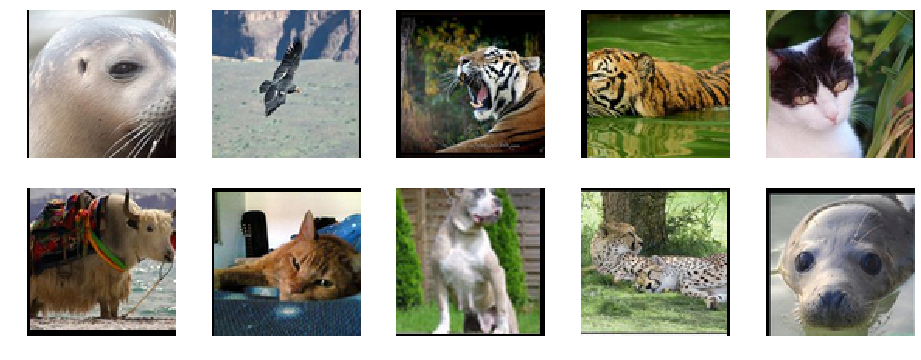

In [5]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    image = np.squeeze(image.numpy())
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
    plt.axis('off');

In [6]:
model = cnn(num_classes=1000)
model.to(device) #move model to cuda if available
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [7]:
def adjust_learning_rate(epoch):
    lr = 0.001

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 120:
        lr = lr / 10000
    elif epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [25]:
def val():
    model.eval()
    val_acc = 0.0
    for i, (images, labels) in enumerate(val_loader):
        images, labels = Variable(images.to(device)), Variable(labels.to(device))

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        val_acc += torch.sum(prediction == labels.data)

    val_acc = val_acc / 64000

    return val_acc

In [16]:
def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        t0 = time.time()
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = Variable(images.to(device)), Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            sys.stdout.write('\r[Epoch: %d/%d - Batch: %d/%d] Train loss: %.4f ' % (epoch+1, num_epochs, i, len(train_loader), loss.item()))

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)

            train_acc += torch.sum(prediction == labels.data)

        adjust_learning_rate(epoch)

        train_acc = train_acc / 64000
        train_loss = train_loss / 64000
        sys.stdout.flush()
        val_acc = val()

        if val_acc > best_acc:
            torch.save(model.state_dict(), args.save)
            best_acc = val_acc

        print("\nTraining Epoch: %d, Acc: %.4f , Loss: %.4f , Val Acc: %.4f, Elapsed: %.1fs" % (epoch, train_acc, train_loss, val_acc, time.time() - t0))

In [17]:
torch.backends.cudnn.benchmark = True

In [26]:
val()

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


RuntimeError: CUDA out of memory. Tried to allocate 81.00 MiB (GPU 0; 11.00 GiB total capacity; 8.60 GiB already allocated; 75.45 MiB free; 65.39 MiB cached)